<a href="https://colab.research.google.com/github/PallottaEnrico/LegalEval/blob/main/Task_A/RR_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LegalEval: Understanding Legal Texts
### Task A

This notebook present a solution for the Task A of the LegalEval challenge from SemEval 2023.

More info about the challenge can be found [here](https://sites.google.com/view/legaleval/home).

[Github link](https://github.com/PallottaEnrico/LegalEval) to our paper and all the utils used here.

Authors:
- Yuri Noviello
- Enrico Pallotta
- Flavio Pinzarrone
- Giuseppe Tanzi


## Task overview
 The purpose of creating a rhetorical role prediction model is to enable automated understanding of legal documents by segmenting them into topically coherent units, referred to as Rhetorical Roles (RR). This segmentation is a fundamental building block for many legal AI applications like judgment summarizing, judgment outcome prediction, precedent search, etc.

## Installations and Imports

In [ ]:
!pip -qqq install dataset
!pip -qqq install transformers
!pip -qqq install wget
!pip -qqq install evaluate
!pip -qqq install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wget
import evaluate
from accelerate import find_executable_batch_size

import torch
import torch.nn as nn
from torch.cuda import empty_cache
from torch.utils.data import DataLoader

import gc
import json
import re
import random
import os

from datasets import Dataset
from tqdm import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report

from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          BatchEncoding,
                          BertModel,
                          TrainingArguments,
                          Trainer)

Long and boring functions have been moved to python modules in our github repo.

The main module are:
- [utils.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_A/utils.py) : contains some utility functions e.g. to plot graphs, examples and confusion matrices.
- [data_preprocessing.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_A/data_preprocessing.py) : contains a function to remap char indexes to word indexes in documents, a function to retrieve the context of a setence inside a document and one to rearrange the dataset into a DataFrame.
- [CustomModel.py](https://github.com/PallottaEnrico/LegalEval/blob/main/Task_A/CustomModel.py) : contains the implementation of our InLegalBERT + BiLSTM model.

In [ ]:
if os.path.exists("LegalEval"):
  !rm -rf LegalEval

!git clone https://github.com/PallottaEnrico/LegalEval.git

from LegalEval.Task_A.data_preprocessing import rearrange_df
from LegalEval.Task_A.utils import (set_reproducibility,
                   labels_frequency,
                   compute_metrics,
                   plot_confusion_matrix,
                   print_document)
from LegalEval.Task_A.CustomModel import BertSequenceClassifier

Cloning into 'LegalEval'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 332 (delta 68), reused 45 (delta 13), pack-reused 190
Receiving objects: 100% (332/332), 429.14 KiB | 8.94 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:
device = "cpu"
if torch.cuda.is_available():
    print('All good, a Gpu is available')
    device = torch.device("cuda:0")

else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


In [ ]:
# Run this cell to guarantee reproducibility.
seed = 42
set_reproducibility(seed)

## Dataset Download

In [ ]:
!wget 'https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json'
!wget 'https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json'

--2023-01-31 17:13:27--  https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13645789 (13M) [application/json]
Saving to: ‘train.json’

train.json          100%[===================>]  13.01M  --.-KB/s    in 0.1s    

2023-01-31 17:13:27 (133 MB/s) - ‘train.json’ saved [13645789/13645789]

--2023-01-31 17:13:27--  https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
train_json = open('train.json')
train = json.load(train_json)

test_json = open('dev.json')
test = json.load(test_json)

## Data Inspection


Spend some time in checking accurately the dataset format and how to retrieve the tasks' inputs and outputs

In [ ]:
print(f"There are {len(train)} documents in the train set")
print(f"There are {len(test)} documents in the test set")

There are 247 documents in the train set
There are 30 documents in the test set


### Conversion in DataFrame format

Let's fix the format of the dataset, passing from json to a structured pandas dataframe containing the useful information.

*i.e. Doc_ID, Full document text, Context, Sentence , Label (RR).* 

- We generate the context of the sentence since we will be using it in some of our experimentations.
- We drop all the duplicates of a `(text, sentence)` pair

In [ ]:
# Define the max length of the input sequence to give to the transformers
MAX_SEQUENCE_LENGTH = 512

In [ ]:
print("Rearranging train..")
train_df = rearrange_df(train, max_len_context=MAX_SEQUENCE_LENGTH)

print("Rearranging test..")
test_df = rearrange_df(test, max_len_context=MAX_SEQUENCE_LENGTH)

Rearranging train..


100%|██████████| 247/247 [01:06<00:00,  3.69it/s]


Rearranging test..


100%|██████████| 30/30 [00:05<00:00,  5.83it/s]


### Exploration

Let's see the final format

In [ ]:
train_df.head()

,doc_id,text,context,sentence,label
0,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",IN THE HIGH COURT OF KARNATAKA CIRCUIT BENCH A...,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",IN THE HIGH COURT OF KARNATAKA CIRCUIT BENCH A...,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",IN THE HIGH COURT OF KARNATAKA CIRCUIT BENCH A...,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",IN THE HIGH COURT OF KARNATAKA CIRCUIT BENCH A...,\n\n This appeal coming on for hearing t...,PREAMBLE
4,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",IN THE HIGH COURT OF KARNATAKA CIRCUIT BENCH A...,\n Heard the learned Counsel for the app...,NONE


Let's see how many sentences there are on average in each document.

In [ ]:
mean_sentences = train_df[['doc_id', 'sentence']].groupby(['doc_id']).count().mean()

print(f'There are about {int(mean_sentences)} sentences in a document.')

There are about 115 sentences in a document.


Let's take a closer look at the distribution of the classes

In [ ]:
labels = train_df['label'].unique().tolist()
n_classes = len(labels)

print(f"There are {n_classes} labels in the dataset.")

There are 13 labels in the dataset.


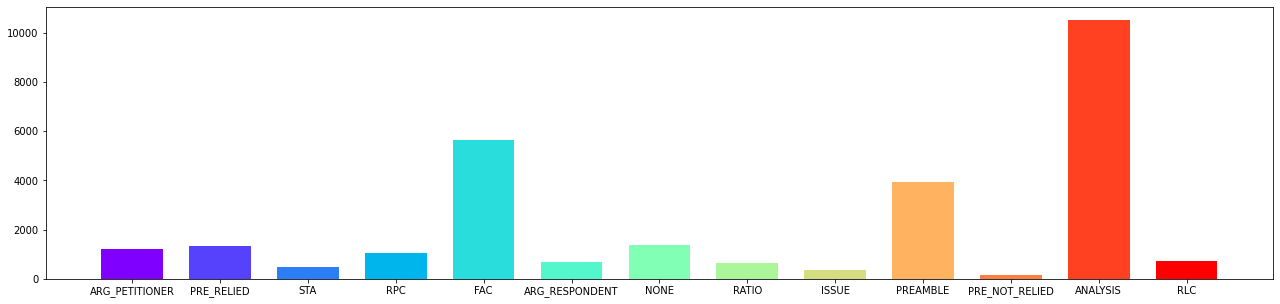

In [ ]:
labels_frequency(train_df)

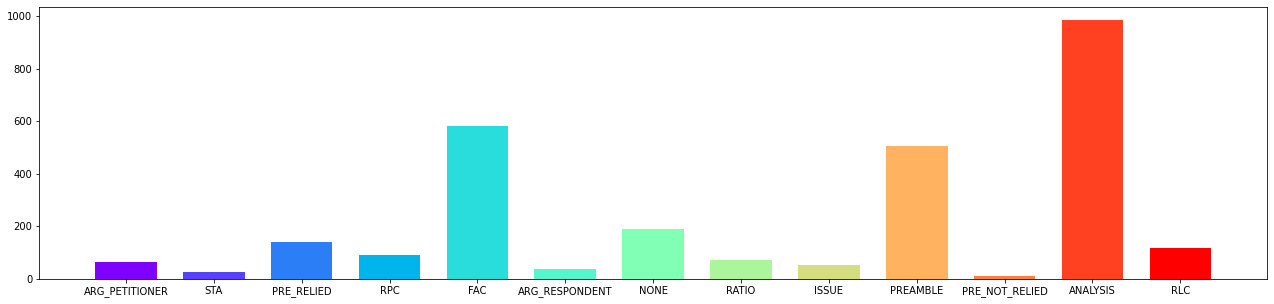

In [ ]:
labels_frequency(test_df)

Let's now look at the mean length in words of the sentences of each class.

In [ ]:
train_df['len_sentence'] = train_df['sentence'].apply(lambda x: len(re.findall(r'\b\S+\b', x)))
train_df.groupby(['label']).mean(['len_sentence'])

,doc_id,len_sentence
label,,
ANALYSIS,3349.340937,29.235719
ARG_PETITIONER,3484.182186,33.051012
ARG_RESPONDENT,3240.173723,32.525547
FAC,3267.932721,25.904114
ISSUE,3482.766484,36.271978
NONE,3784.358531,12.338373
PREAMBLE,3670.658401,18.800607
PRE_NOT_RELIED,3420.256410,38.596154
PRE_RELIED,3320.390171,37.549516


As one can see there are some classes that are characterized by longer sentences like Statute (STA) and Precedent Not Relied (PRE_NOT_RELIED).

When creating the context we included also the center sentence. This means that if a sentence has more than 256 words, the context will be missing.

Let's take a look at the examples that have no context.

In [ ]:
train_df[train_df['context'] == ""]

,doc_id,text,context,sentence,label,len_sentence
2474,4236,IN THE COURT OF THE IV ADDL DISTRICT AND\n ...,,Ex.P. 1 Complaint Ex.P.\nEx.P. 1(a) Signatu...,NONE,258
2887,4157,Non-Reportable\...,,"\n Charges 5 & 6 are as follows: ""\n Fifth...",ANALYSIS,278
3483,4173,"PETITIONER:\nSALES TAX OFFICER, SPECIAL CIRCLE...",,Subsection (3) of section 20-A of the Bihar Sa...,ANALYSIS,259
4823,1729,...,,The Public Prosecutor or Assistant Public Pros...,STA,267
9757,1777,...,,Death sentence must be imposed only when life ...,ANALYSIS,306
16785,1754,$~23 & 24 (common order)\n IN THE HIGH COU...,,\n 11. The prosecution led evidence by exa...,FAC,335
19260,4265,"PETITIONER:\nCOMMISSIONER OF INCOME-TAX, NEW D...",,These read thus: S. 16(2)-For the purposes of ...,STA,370
19261,4265,"PETITIONER:\nCOMMISSIONER OF INCOME-TAX, NEW D...",,\nIf the Central Government considers it neces...,STA,331
24102,1743,PETITIONER:\nSTATE OF TAMIL NADU\n\n Vs.\n\...,,Sub-section (1) of section 10A which is materi...,STA,258
26133,4194,$~\n* IN THE HIGH COURT OF DELHI AT NEW ...,,\n 6. Para 4 of the Memorandum of the Assessee...,FAC,268


In [ ]:
print("Number of sentence without context: ", len(train_df[train_df['context'] == ""]))

Number of sentence without context:  11


## Train val split


The authors of the challenge provided two annotated dataset:
- a training set
- a development set

A non annotated test set was also provided in order to compute the metrics for the leaderboard.

While testing our solutions we splitted the train set into train and validation (90:10) and used the development set to evaluate the generalization of our model on unseen data.

In [ ]:
splitter = GroupShuffleSplit(test_size=.1, n_splits=1)  # 90% train, 10% val
split = splitter.split(train_df, groups=train_df['text'])
train_inds, test_inds = next(split)

train_set_df = train_df.iloc[train_inds]
val_set_df = train_df.iloc[test_inds]

## Preprocessing functions

In this section we define all the functions that are needed in order to transform the raw text in the dataframe into batch of token sequences to be processed by the models. In particular:
- a function that tokenizes a batch of samples with a given tokenizer
- a function that transforms the training set and the validation set from the DataFrame format to the HuggingFace Dataset format

In [ ]:
# Maps the labels to id and viceversa
id2label = {i: x for i, x in enumerate(labels)}
label2id = {i: x for x, i in enumerate(labels)}

labels_true = test_df['label'].apply(lambda x: label2id[x]).to_list()

# Max sentence length for the single sentence baseline models
max_sentence_length = int(np.quantile([len(seq.split(' ')) for seq in train_df['sentence']], 0.99))

In [ ]:
def preprocess_function(batch,
                        tokenizer: AutoTokenizer,
                        context: bool) -> BatchEncoding:
    """
      Preprocesses a batch of samples to get the tokenized input to give to the transformer

      Params:
        batch: batch of samples
        tokenizer: tokenizer used for the tokenization of the input

      Returns:
        inputs: a BatchEncoding instance to give as input to the transformer
    """

    if context:
        inputs = tokenizer(batch['sentence'],
                           batch['context'],
                           padding="max_length",
                           truncation=True,  # truncate the longest
                           max_length=MAX_SEQUENCE_LENGTH)
    else:
        inputs = tokenizer(batch['sentence'],
                           padding="max_length",
                           truncation=True,  # truncate the longest
                           max_length=max_sentence_length)

    return inputs

In [ ]:
def get_processed_datasets(train_set_df: pd.DataFrame,
                           val_set_df: pd.DataFrame,
                           tokenizer: AutoTokenizer,
                           context: bool) -> (Dataset, Dataset):
    """
      Preprocesses the dataset given as input with the tokenizer and it converts them in Dataset format

      Params:
        train_set_df: train-set in DataFrame format
        val_set_df: validation-set in DataFrame format

      Returns:
        the train data and the validation data in Dataset format with the input format useful for the transformer
    """

    # avoid possible confilct with other training
    train_set = train_set_df.copy()
    val_set = val_set_df.copy()

    print("Processing training data")

    # remap labels to ids
    train_set['label'] = train_set_df['label'].apply(lambda x: label2id[x])
    train_set_ds = Dataset.from_pandas(train_set)

    train_data = train_set_ds.map(
        preprocess_function,
        fn_kwargs={'tokenizer': tokenizer, 'context': context},
        batched=True,
        remove_columns=[col for col in train_set_ds.column_names if col != 'label']
    )

    print("Processing validation data")

    # remap labels to ids
    val_set['label'] = val_set_df['label'].apply(lambda x: label2id[x])
    val_set_ds = Dataset.from_pandas(val_set)

    val_data = val_set_ds.map(
        preprocess_function,
        fn_kwargs={'tokenizer': tokenizer, 'context': context},
        batched=True,
        remove_columns=[col for col in val_set_ds.column_names if col != 'label']
    )

    return train_data, val_data

## Models Definition


In this section we define all the models on which we will perform our experiments, together with a function to retrieve a model and its respective tokenizer through the HuggingFace API.

In [ ]:
model_name_M0 = 'bert-base-uncased'
model_name_M1 = 'roberta-base'
model_name_M2 = 'saibo/legal-roberta-base'
model_name_M3 = 'law-ai/InLegalBERT'

baseline_1 = 'single_sentence_bert'
baseline_2 = 'single_sentence_roberta'
model_0 = 'single_sentence_inlegalbert_bilstm'
model_1 = 'context_aware_legal_roberta'
model_2 = 'context_aware_inlegalbert'

In [ ]:
def get_model_tok(bert_name: str,
                  num_labels: int,
                  context: bool,
                  model_path: str = None,
                  is_custom: bool = False,
                  ) -> (AutoModelForSequenceClassification, AutoTokenizer):
    """
    Returns the model and the tokenizer loaded from huggingface, if no model_path
    is provided, otherwise it load the model from the given directory.

    Params:
      bert_name: model name from huggingface
      num_labels: number of classes
      model_path: [optional] path of the saved model

    Returns:
      the transformer model and its corresponding tokenizer
    """

    if model_path is None:
        model_path = bert_name

    tokenizer = AutoTokenizer.from_pretrained(bert_name,
                                              use_cache=False)

    print("Downloading :", bert_name)
    if is_custom:
        model = BertSequenceClassifier(bert_name=model_path,
                                       num_classes=n_classes,
                                       id2label = id2label,
                                       label2id = label2id)
        model.bert.config.eos_token_id = tokenizer.eos_token_id
        model.bert.config.pad_token_id = tokenizer.pad_token_id
        model.bert.config.cls_token_id = tokenizer.cls_token_id
        model.bert.config.max_new_tokens = model.bert.config.max_length = MAX_SEQUENCE_LENGTH

    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id,
                                                                   use_cache=False)
        model.config.eos_token_id = tokenizer.eos_token_id
        model.config.pad_token_id = tokenizer.pad_token_id
        model.config.cls_token_id = tokenizer.cls_token_id
        model.config.max_new_tokens = model.config.max_length = MAX_SEQUENCE_LENGTH if context else max_sentence_length

    return model, tokenizer

## Training & Evaluation functions

In this section we define two functions to execute either the training or the evaluation pipeline.

In both pipelines we use the HuggingFace Trainer object to perform both the training and the inference. The Trainer needs to be configured with some TrainingArguments which are defined in the training pipeline before its instantiation.

Default hyperparameters:
- Number of epochs: 3
- Batch Size: 16
- Learning rate: 2e-5
- Optimizer: AdamW
- Scheduler: linear
- Weight decay: 0.01
- Label smoothing: 0.02
- Precision: 16-bit

In [ ]:
def exec_train_pipeline(model_name: str,
                        output_dir: str,
                        num_labels: int,
                        batch_size: int = 16,
                        n_epochs: int = 3,
                        context: bool = True,
                        is_custom: bool = False,
                        model_trained: bool = False,
                        num_workers: int = 2):
    """
    Params:
      model_name : official name of the model
      output_dir : directory where the model will be saved
      num_labels : num_labels : number of classes
      model_trained : whether the model was already trained or not
    Returns:
      trainer: the trainer used to train the model
      tokenizer: the tokenizer used to tokenize the train and the validation set
    """

    # removing cached file to avoid any possible conflict between consecutive model trainings
    print("Cleaning memory...")
    !rm -rf ./root/.cache/huggingface/hub/model*
    empty_cache()
    gc.collect()

    if model_trained:
        try:
            model, tokenizer = get_model_tok(model_name,
                                             num_labels=num_labels,
                                             model_path=output_dir,
                                             is_custom=is_custom,
                                             context=context)
        except:
            print('No model found!')
            return None, None
    else:
        model, tokenizer = get_model_tok(model_name,
                                         num_labels=num_labels,
                                         is_custom=is_custom,
                                         context=context)

    # tokenization and conversion to dataset format
    train_data, val_data = get_processed_datasets(train_set_df, val_set_df, tokenizer,
                                                  context=context)

    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        eval_steps=1, # evaluate at each epoch
        fp16=True,  # speed up a bit the training
        auto_find_batch_size=True,  # Starts from given batch size, decreases it if needed
        dataloader_num_workers=num_workers,
        optim = 'adamw_torch', # avoids optimizer warnings
        full_determinism=True,
        label_smoothing_factor=0.2 if not is_custom else 0,
        logging_steps=100
    )

    # instantiate trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    if not model_trained:
        trainer.train()
        trainer.save_model()

    # important to avoid out of memory errors
    del model

    # return both the trainer and the tokenizer since they will be
    # reused during the evaluation pipeline to perform predictions
    return trainer, tokenizer

Define a function that performs inference on the test set computing model predictions.

In [ ]:
def exec_eval_pipeline(trainer: Trainer,
                       tokenizer: AutoTokenizer,
                       test_set_df: pd.DataFrame,
                       context: bool):
    """
    Params:
      trainer : the trainer used to the train the model (will be used in predict mode)
      tokenizer : the tokenizer used for the train set
      test_set_df : pandas DataFrame containing the test set
    Returns:
      predictions: the predictions of the trained model on the test dataset
    """

    print("Processing test data")
    test_set = test_set_df.copy()
    test_set_ds = Dataset.from_pandas(test_set)

    test_data = test_set_ds.map(
        preprocess_function,
        fn_kwargs={'tokenizer': tokenizer, 'context': context},
        batched=True,
        remove_columns=test_set_ds.column_names
    )

    predictions, _, _ = trainer.predict(test_data)

    return predictions

## Models Performance

Now we proceed with the training of all the models. The baselines and Model 0 have been trained with a higher batch size (128) in order to speed up a bit the training process. Unfortunately this wasn't possible with the context aware models, since their input is bigger and doesn't fit in the GPU memory provided by Colab.

For each model we also evaluated its performances on the test set and printed its classification report.

## Baseline models
First we define two baseline models consisting of a simple transformer with a linear layer on top of it for sentence classification. Following the experiments done in the [corpus paper](https://arxiv.org/pdf/2201.13125.pdf)  we reproduced the results obtained with the mentioned baseline, using both BERT and RoBERTa as transformers modules.

### Baseline 1 - Single Sentence BERT

##### Training

In [ ]:
trainer_baseline_1, tokenizer_baseline_1 = exec_train_pipeline(model_name_M0, baseline_1, n_classes, batch_size=128, context = False)

Cleaning memory...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Processing training data


  0%|          | 0/26 [00:00<?, ?ba/s]

Processing validation data


  0%|          | 0/4 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 25178
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 591
  Number of trainable parameters = 109492237
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to enco

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1
1,2.019300,1.646237,0.652714,0.630991
2,1.660700,1.609034,0.652714,0.638742
3,1.572200,1.616276,0.649117,0.637228


***** Running Evaluation *****
  Num examples = 3058
  Batch size = 128
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Saving model checkpoint to single_sentence_bert/checkpoint-197
Configuration saved in single_sentence_bert/checkpoint-197/config.json
Model weights saved in single_sentence_bert/checkpoint-197/pytorch_model.bin
tokenizer config file saved in single_sentence_bert/checkpoint-197/tokenizer_config.json
Special tokens file saved in single_sentence_bert/checkpoint-197/special_tokens_map.json
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 3058
  Batch size = 128
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, usi

##### Evaluation

In [ ]:
logits_b1 = exec_eval_pipeline(trainer_baseline_1, tokenizer_baseline_1, test_df, context=False)

Processing test data


  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2878
  Batch size = 128
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions_b1 = [np.argmax(pred) for pred in logits_b1]
print(classification_report(labels_true, predictions_b1, target_names=label2id.keys()))

                precision    recall  f1-score   support

      PREAMBLE       0.89      0.62      0.73       507
          NONE       0.92      0.78      0.84       190
           FAC       0.61      0.74      0.67       581
ARG_RESPONDENT       0.00      0.00      0.00        38
           RLC       0.45      0.16      0.23       116
ARG_PETITIONER       0.24      0.23      0.24        65
      ANALYSIS       0.60      0.80      0.69       985
    PRE_RELIED       0.62      0.32      0.42       142
         RATIO       0.00      0.00      0.00        71
           RPC       0.67      0.80      0.73        92
         ISSUE       0.83      0.67      0.74        51
           STA       0.62      0.54      0.58        28
PRE_NOT_RELIED       0.00      0.00      0.00        12

      accuracy                           0.65      2878
     macro avg       0.50      0.43      0.45      2878
  weighted avg       0.64      0.65      0.63      2878



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline 2 - Single sentence RoBERTa


##### Training

In [ ]:
trainer_baseline_2, tokenizer_baseline_2 = exec_train_pipeline(model_name_M1, baseline_2, n_classes, batch_size=128, context=False)

Cleaning memory...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Processing training data


  0%|          | 0/26 [00:00<?, ?ba/s]

Processing validation data


  0%|          | 0/4 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 25178
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 591
  Number of trainable parameters = 124655629
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method t

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1
1,1.961300,1.551706,0.679202,0.662026
2,1.560600,1.517500,0.685088,0.670459
3,1.486000,1.531061,0.678875,0.670369


***** Running Evaluation *****
  Num examples = 3058
  Batch size = 128
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Saving model checkpoint to single_sentence_roberta/checkpoint-197
Configuration saved in single_sentence_roberta/checkpoint-197/config.json
Model weights saved in single_sentence_roberta/checkpoint-197/pytorch_model.bin
tokenizer config file saved in single_sentence_roberta/checkpoint-197/tokenizer_config.json
Special tokens file saved in single_sentence_roberta/checkpoint-197/special_tokens_map.json
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 3058
  Batch size = 128
You're using a RobertaTokenizerFast tokenizer. Please note that wi

##### Evaluation

In [ ]:
logits_b2 = exec_eval_pipeline(trainer_baseline_2, tokenizer_baseline_2, test_df, context=False)

Processing test data


  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2878
  Batch size = 128
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions_b2 = [np.argmax(pred) for pred in logits_b2]
print(classification_report(labels_true, predictions_b2, target_names=label2id.keys()))

                precision    recall  f1-score   support

      PREAMBLE       0.97      0.93      0.95       507
          NONE       0.91      0.85      0.88       190
           FAC       0.67      0.71      0.69       581
ARG_RESPONDENT       0.00      0.00      0.00        38
           RLC       0.64      0.24      0.35       116
ARG_PETITIONER       0.25      0.29      0.27        65
      ANALYSIS       0.64      0.81      0.72       985
    PRE_RELIED       0.80      0.30      0.44       142
         RATIO       1.00      0.01      0.03        71
           RPC       0.73      0.79      0.76        92
         ISSUE       0.73      0.71      0.72        51
           STA       0.57      0.57      0.57        28
PRE_NOT_RELIED       0.00      0.00      0.00        12

      accuracy                           0.72      2878
     macro avg       0.61      0.48      0.49      2878
  weighted avg       0.72      0.72      0.70      2878



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 0 - Single Sentence InLegalBert + BiLSTM

We then consider a model that utilizes a
pre-trained BERT embedding module, specifically
InLegalBERT, which was trained on Indian
legal documents. The module is then followed by
the integration of two Bi-LSTM layers and a linear
classifier, with an average pooling operation performed at token level between the two LSTM layers

#### Training

In [ ]:
trainer_model_0, tokenizer_model_0 = exec_train_pipeline(model_name_M3, model_0, n_classes, batch_size=128, context = False, is_custom = True)

Cleaning memory...


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/config.json
Model config BertConfig {
  "_name_or_path": "law-ai/InLegalBERT",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "PREAMBLE",
    "1": "NONE",
    "2": "FAC",
    "3": "ARG_RESPONDENT",
    "4": "RLC",
    "5": "ARG_PETITIONER",
    "6": "ANALYSIS",
    "7": "PRE_RELIED",
    "8": "RATIO",
    "9": "RPC",
    "10": "ISSUE",
    "11": "STA",
    "12": "PRE_NOT_RELIED"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ANALYSIS": 6,
    "ARG_PETITIONER": 5,
    "ARG_RESPONDENT": 3,
    "FAC": 2,
    "ISSUE": 10,
    "NONE": 1,
    "PREAMBLE": 0,
    "PRE_NOT_RELIED": 12,
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/pytorch_model.bin
Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassific

Processing training data


  0%|          | 0/26 [00:00<?, ?ba/s]

Processing validation data


  0%|          | 0/4 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `BertSequenceClassifier.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertSequenceClassifier.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25178
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 591
  Number of trainable parameters = 113167117
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` m

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1
1,2.210600,1.671797,0.615435,0.549958
2,1.845900,1.609665,0.650752,0.606160
3,1.740000,1.601834,0.654676,0.619234


The following columns in the evaluation set don't have a corresponding argument in `BertSequenceClassifier.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertSequenceClassifier.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3058
  Batch size = 128
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to single_sentence_inlegalbert_bilstm/checkpoint-197
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in single_sentence_inlegalbert_bilstm

#### Evaluation

In [ ]:
logits_m0 = exec_eval_pipeline(trainer_model_0, tokenizer_model_0, test_df, context=False)

Processing test data


  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertSequenceClassifier.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertSequenceClassifier.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2878
  Batch size = 128
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions_m0 = [np.argmax(pred) for pred in logits_m0]
print(classification_report(labels_true, predictions_m0, target_names=label2id.keys()))

                precision    recall  f1-score   support

      PREAMBLE       0.89      0.66      0.76       507
          NONE       0.89      0.83      0.86       190
           FAC       0.61      0.80      0.70       581
ARG_RESPONDENT       0.00      0.00      0.00        38
           RLC       0.00      0.00      0.00       116
ARG_PETITIONER       0.60      0.05      0.09        65
      ANALYSIS       0.59      0.84      0.69       985
    PRE_RELIED       0.63      0.08      0.15       142
         RATIO       0.00      0.00      0.00        71
           RPC       0.55      0.79      0.65        92
         ISSUE       0.00      0.00      0.00        51
           STA       0.00      0.00      0.00        28
PRE_NOT_RELIED       0.00      0.00      0.00        12

      accuracy                           0.65      2878
     macro avg       0.37      0.31      0.30      2878
  weighted avg       0.60      0.65      0.60      2878



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Context aware models

Drawing inspiration from [RR segmentation paper](https://arxiv.org/pdf/2112.01836.pdf), we propose a solution that enables reasoning on the context of the sentences when classifying.
We evaluate two models with the same architecture as the baselines, utilizing pre-trained transformers, Legal-RoBERTa and InLegalBert (respectively pre-trained on american legal documents and indian legal documents). These models are fed with the sentence and its context to enable the BERT modules to generate contextually enriched sentence embeddings, which are then fed into a linear classifier to output classes predictions.

#### Model 1 - Context aware Legal RoBERTa

##### Training

In [ ]:
trainer_model_1, tokenizer_model_1 = exec_train_pipeline(model_name_M2, model_1, n_classes, context=True)

Cleaning memory...


Some weights of the model checkpoint at saibo/legal-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at saibo/legal-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.b

Processing training data


  0%|          | 0/26 [00:00<?, ?ba/s]

Processing validation data


  0%|          | 0/4 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 25178
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4722
  Number of trainable parameters = 124655629
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1
1,1.241800,1.476661,0.727927,0.729940
2,1.106000,1.447848,0.764225,0.765040
3,1.068200,1.512816,0.758993,0.764114


***** Running Evaluation *****
  Num examples = 3058
  Batch size = 16
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Saving model checkpoint to context_aware_legal_roberta/checkpoint-1574
Configuration saved in context_aware_legal_roberta/checkpoint-1574/config.json
Model weights saved in context_aware_legal_roberta/checkpoint-1574/pytorch_model.bin
tokenizer config file saved in context_aware_legal_roberta/checkpoint-1574/tokenizer_config.json
Special tokens file saved in context_aware_legal_roberta/checkpoint-1574/special_tokens_map.json
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 3058
  Batch size = 16
You're using a RobertaTokenizerFast tokeni

##### Evaluation

In [ ]:
logits_m1 = exec_eval_pipeline(trainer_model_1, tokenizer_model_1, test_df, context=True)

Processing test data


  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2878
  Batch size = 16
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions_m1 = [np.argmax(pred) for pred in logits_m1]
print(classification_report(labels_true, predictions_m1, target_names=label2id.keys()))

                precision    recall  f1-score   support

      PREAMBLE       0.94      1.00      0.97       507
          NONE       0.91      0.86      0.89       190
           FAC       0.82      0.86      0.84       581
ARG_RESPONDENT       0.44      0.50      0.47        38
           RLC       0.55      0.22      0.32       116
ARG_PETITIONER       0.59      0.20      0.30        65
      ANALYSIS       0.77      0.87      0.81       985
    PRE_RELIED       0.69      0.39      0.50       142
         RATIO       0.47      0.48      0.48        71
           RPC       0.88      0.89      0.89        92
         ISSUE       0.81      0.75      0.78        51
           STA       0.63      0.68      0.66        28
PRE_NOT_RELIED       0.00      0.00      0.00        12

      accuracy                           0.80      2878
     macro avg       0.65      0.59      0.61      2878
  weighted avg       0.79      0.80      0.79      2878



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Model 2 - Context aware InLegalBERT

##### Training

In [ ]:
trainer_model_2, tokenizer_model_2 = exec_train_pipeline(model_name_M3, model_2, n_classes, context=True)

Cleaning memory...


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/config.json
Model config BertConfig {
  "_name_or_path": "law-ai/InLegalBERT",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "PREAMBLE",
    "1": "NONE",
    "2": "FAC",
    "3": "ARG_RESPONDENT",
    "4": "RLC",
    "5": "ARG_PETITIONER",
    "6": "ANALYSIS",
    "7": "PRE_RELIED",
    "8": "RATIO",
    "9": "RPC",
    "10": "ISSUE",
    "11": "STA",
    "12": "PRE_NOT_RELIED"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ANALYSIS": 6,
    "ARG_PETITIONER": 5,
    "ARG_RESPONDENT": 3,
    "FAC": 2,
    "ISSUE": 10,
    "NONE": 1,
    "PREAMBLE": 0,
    "PRE_NOT_RELIED": 12,
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--law-ai--InLegalBERT/snapshots/6dc9118c93627cca0137cf1df0fade4e84d5020e/pytorch_model.bin
Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to b

Processing training data


  0%|          | 0/26 [00:00<?, ?ba/s]

Processing validation data


  0%|          | 0/4 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 25178
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4722
  Number of trainable parameters = 109492237
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method t

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1
1,1.217200,1.381585,0.775016,0.770284
2,1.103200,1.415368,0.783519,0.783531
3,1.061800,1.447880,0.784500,0.785434


***** Running Evaluation *****
  Num examples = 3058
  Batch size = 16
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to context_aware_inlegalbert/checkpoint-1574
Configuration saved in context_aware_inlegalbert/checkpoint-1574/config.json
Model weights saved in context_aware_inlegalbert/checkpoint-1574/pytorch_model.bin
tokenizer config file saved in context_aware_inlegalbert/checkpoint-1574/tokenizer_config.json
Special tokens file saved in context_aware_inlegalbert/checkpoint-1574/special_tokens_map.json
You're using a BertTokenizerFast tokenizer. Please note th

##### Evaluation

In [ ]:
logits_m2 = exec_eval_pipeline(trainer_model_2, tokenizer_model_2, test_df, context=True)

Processing test data


  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2878
  Batch size = 16
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions_m2 = [np.argmax(pred) for pred in logits_m2]
print(classification_report(labels_true, predictions_m2, target_names=label2id.keys()))

                precision    recall  f1-score   support

      PREAMBLE       0.98      1.00      0.99       507
          NONE       0.96      0.86      0.91       190
           FAC       0.81      0.89      0.85       581
ARG_RESPONDENT       0.64      0.74      0.68        38
           RLC       0.66      0.27      0.38       116
ARG_PETITIONER       0.57      0.18      0.28        65
      ANALYSIS       0.78      0.90      0.84       985
    PRE_RELIED       0.74      0.44      0.55       142
         RATIO       0.70      0.37      0.48        71
           RPC       0.83      0.92      0.88        92
         ISSUE       0.66      0.78      0.71        51
           STA       0.50      0.68      0.58        28
PRE_NOT_RELIED       0.00      0.00      0.00        12

      accuracy                           0.82      2878
     macro avg       0.68      0.62      0.62      2878
  weighted avg       0.81      0.82      0.81      2878



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Error analysis

In this section we considered only the two best models according to their scores on the test set and further analysed their performances in terms of quality of the predictions and misclassification errors by plotting their confusion matrices. We then looked into a couple of document predictions from our best model (Context aware InLegalBERT) to see some error examples.

### Model 1 - Context aware Legal RoBERTa

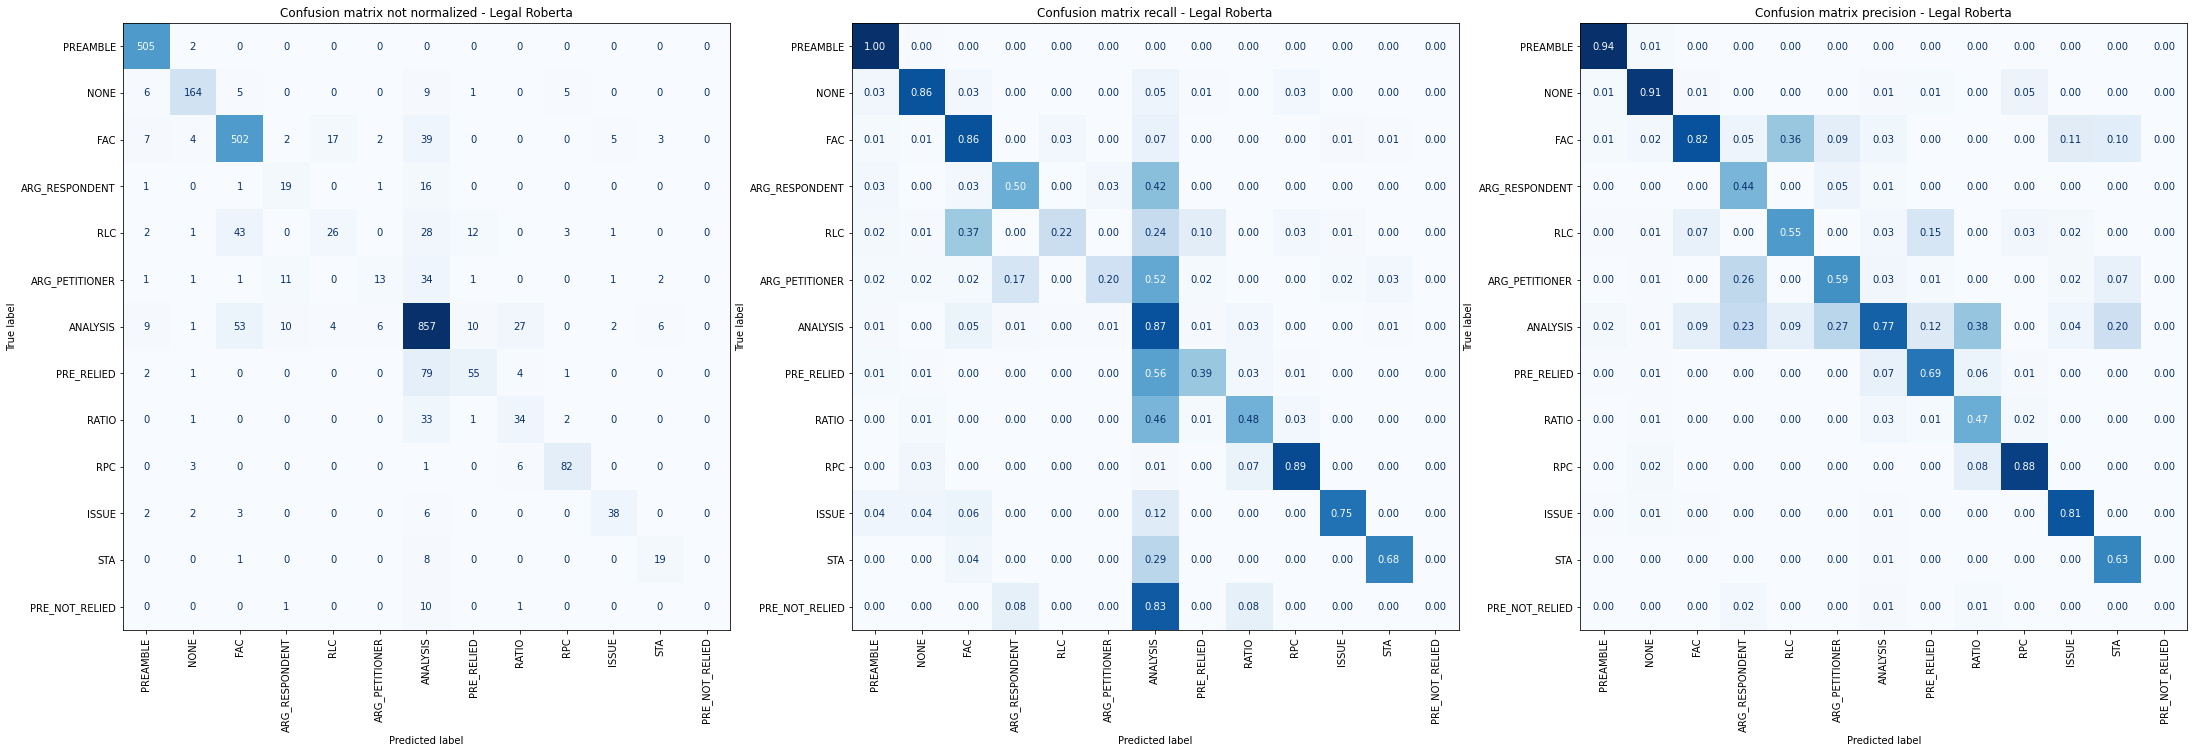

In [ ]:
plot_confusion_matrix(true = labels_true,
                      predictions = predictions_m1,
                      labels_name = labels,
                      model_name = 'Legal Roberta')

### Model 2 - Context aware InLegalBERT

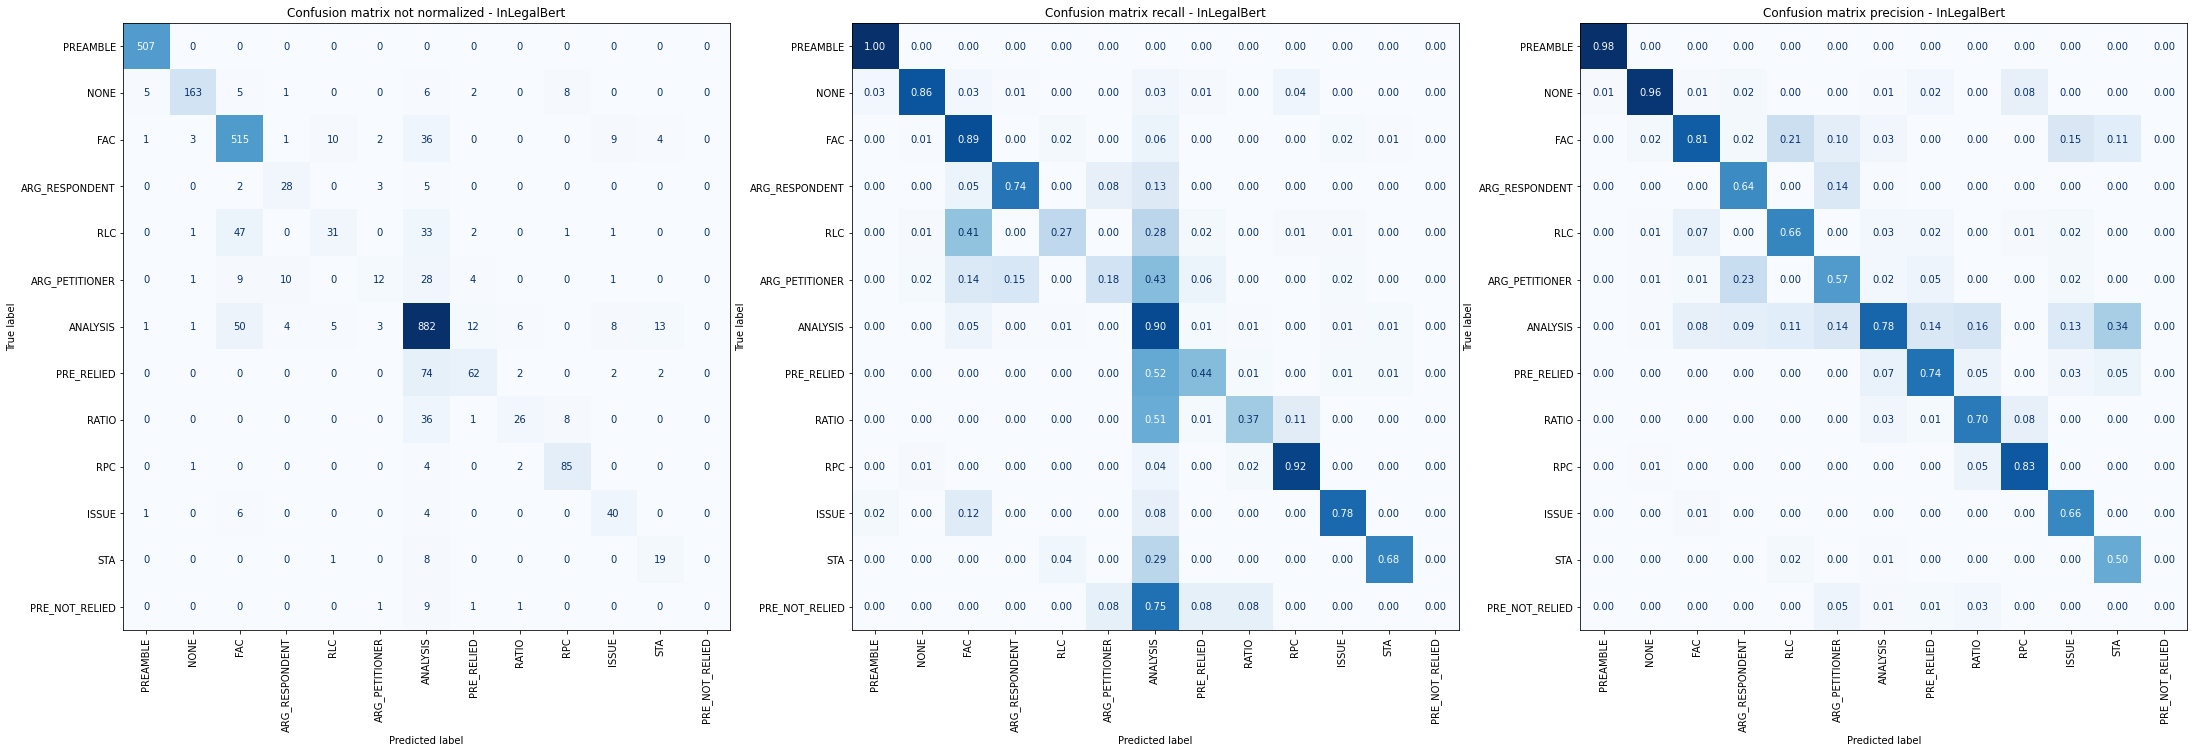

In [ ]:
plot_confusion_matrix(true = labels_true,
                      predictions = predictions_m2,
                      labels_name = labels,
                      model_name = 'InLegalBert')

As can be observed from the confusion matrices, ARGUMENTS roles, PRECEDENT roles and RATIO are heavily miss-classified with the majority class ANALYSIS.
This behaviour is probably related to the fact that sentences belonging to the core section of a document all contain discussions of the court or statements from the parts, which only differ for the subject of the discussion (whether it is a precedent case or not) or for the part that is speaking (whether it is the petitioner or the respondent). Moreover PRE_NOT_RELIED is never correctly classified, due to its low frequency in the dataset. 

RLC and STATUTE are both missclassified as ANALYSIS more than 25% of the times, while RLC is often misclassified with FAC, as also happened to human dataset annotators.

PREAMBLE is almost perfectly classified, probably due to the fact that they almost always include proper nouns, repeated formulas, dates and other highly recognizable patterns.

Some other classes like FAC, NONE, ANALYSIS and RPC reach high F1-score values. It is important to note that in the RPC class the model has a recall of 92\%, meaning that it correctly identifies the final judgement of the court in most of the cases (even if it has a small support in the dataset).

In the confusion matrices from our best model we can see some improvements:
- ARG_RESPONDENT is much fewer times confused with ANALYSIS, resultig in a big increase in its F1 score
- The F1 scores of PREAMBLE, NONE, FAC, RLC and PRE_RELIED slighlty increased.

### Error examples

We plot the inference output of InLegalBERT on two different documents, highlighting in red misclassification errors.

#### Example 1

In [ ]:
print_document(test_df, labels_true, predictions_m2, id2label, doc_id = 4205)

|True class	|Predicted class|
|---------------|---------------|
|PREAMBLE  	|PREAMBLE	|	PETITIONER: BED RAJ Vs. RESPONDENT:
|PREAMBLE  	|PREAMBLE	|	THE STATE OF UTTAR PRADESH.
|PREAMBLE  	|PREAMBLE	|	DATE OF JUDGMENT: 28/09/1955 BENCH:
|PREAMBLE  	|PREAMBLE	|	BOSE, VIVIAN BENCH: BOSE, VIVIAN JAGANNADHADAS, B. SINHA, BHUVNESHWAR P. CITATION: 1955 SCR (2) 583 1955 AIR 778 ACT: Sentence, Enhancement of-By the High Court-Principles applicable thereto. HEADNOTE: A question of sentence is a matter of discretion and it is well settled that when discretion has been properly exercised along accepted judicial lines, an appellate court
|PREAMBLE  	|PREAMBLE	|	should not interfere to the detriment of an accused person except for very strong reasons which must be disclosed on
|PREAMBLE  	|PREAMBLE	|	the face of the judgment
|PREAMBLE  	|PREAMBLE	|	. In a matter of enhancement there should not be interference when the sentence passed imposes substantial punishment.
|PREAMBLE  	|PREAMBLE	|	Interferen

From this example, you can notice that the model tends to misclassify a short sequence of RLC-sentences within a long sequence of FAC-sentences. This could be due to the ambiguous labelling of this sentences, since they are very similar to facts as they report previous events. Looking at the RLC tagged sentences which precede and follow the misclassified sequence (which have been correctly classified), they contain words such as *Judge*, *Appeal*, *sentenced* and *High Court*, along with past verbs. Hence they are easier to be classified as Ruling by Previous Court. 
Moreover, in this example the model predicts ANALYSIS also for the first two sentences after the end of the ANALYSIS paragraph, since the following sentences are the last ones of the documents and bring less context information.

#### Example 2

In [ ]:
print_document(test_df, labels_true, predictions_m2, id2label, doc_id = 4178)

|True class	|Predicted class|
|---------------|---------------|
|PREAMBLE      	|PREAMBLE      	|	PETITIONER: VEERA IBRAHIM Vs. RESPONDENT: STATE OF MAHARASHTRA DATE OF JUDGMENT18/03/1976 BENCH: SARKARIA, RANJIT SINGH
|PREAMBLE      	|PREAMBLE      	|	BENCH: SARKARIA, RANJIT SINGH UNTWALIA, N.L. CITATION: 1976 SCR (3) 672 1976 AIR 1167 1976 SCC (2) 302 ACT: Constitution of India, Art 20(3), conditions for applicability of, whether enquiry is `accusation' within the meaning of-Evidence Act, S 24, when attracted-What amounts to `confession' under S. 24. HEADNOTE: A truck was seized with its content of contraband goods for foreign make, on which no duty had been paid.
|PREAMBLE      	|PREAMBLE      	|	The appellant who was in charge of the goods, was arrested while escaping from the truck and Rs. 2000/- were seized from him.
|PREAMBLE      	|PREAMBLE      	|	His statement was recorded under S. 108, Customs Act, 1962.
|PREAMBLE      	|PREAMBLE      	|	The appellant and the driver of the tr

As previously noted in the confusion matrix, this example shows as ARG_PETITIONER and PRE_RELIED are almost always misclassified with ANALYSIS. In particular, the first sentence of the PRE_RELIED paragraph was correctly classified since it contained a direct reference to a previous case (*In R. C. Mehta v. State of West Bengal*). However, the following related sentences were wrongly classifyied as ANALYSIS and one was classyfied as STATUTE. This last misclassification could be due to the fact that the sentence contains a citation of a previous court about a statute. (*Shah J., speaking for the Court, made these apposite observations: "Under s. 171-A of the Sea Customs Act ...*)

## Conclusion

Our study showed that InLegalBERT with a context-aware approach outperforms other models in identifying Rhetorical Roles in legal documents, with a Micro-F1 score of 0.82. The introduction of the context as input enabled the model to gather more information from the semantic meaning of the surrounding sentences, that resulted in more effective sentence embeddings when predicting the Rhetorical Role. This approach effectively classify sentences belonging to the beginning (PREAMBLE) and ending (RPC) of legal documents but further improvement is needed to differentiate similar discussions (ANALYSIS, PRECEDENTS, ARGUMENTS) in Court Appeals. As a future work, we aim to enhance the model's differentiation capabilities to improve its performance in the legal domain.

To submit our results and participate in the challenge, InLegaBERT was then retrained using all the available annotated data (the union of the training and the development set) in order to be sure to maximize performances. The model obtained a Micro-F1 score of 81.12\% on the submission data, that resulted in the 8th position in the leaderboard.

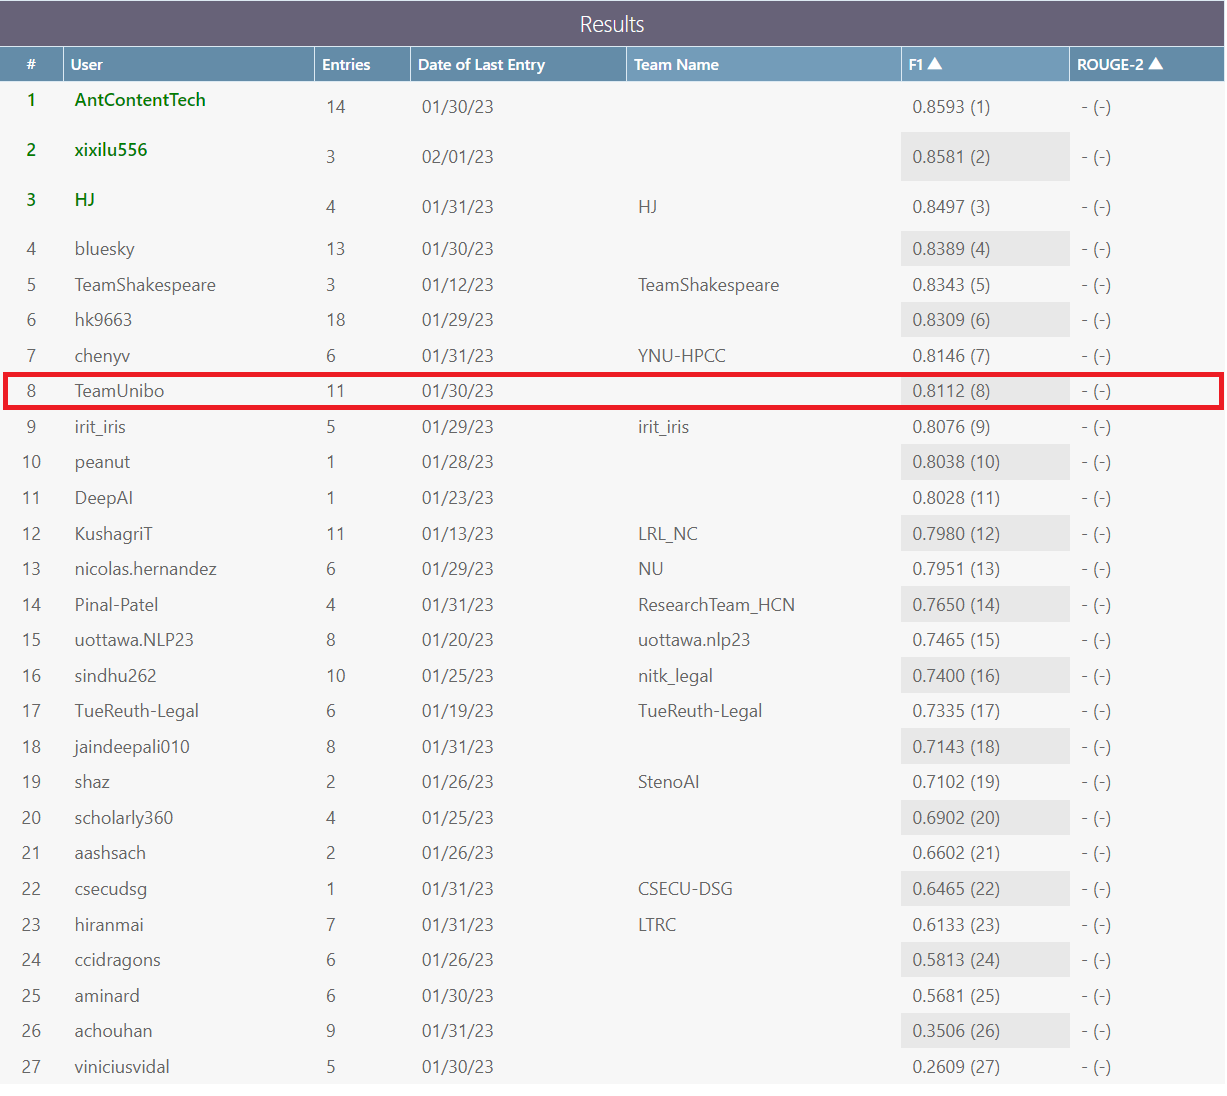

## Code for submission

In order to submit our solution to the challenge we have to download the test dataset and then modify it by substituting all the "DUMMY" labels with the predictions made by our model.

The following cell imports and loads the testing dataset.

Unfortunately this dataset is not publicly available, since it was distributed to the challenge participants only.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

test_new_json = open('/content/drive/MyDrive/RR_TEST_DATA_FS.json')

Mounted at /content/drive


In [ ]:
test_new = json.load(test_new_json)
test_df_new = rearrange_df(test_new, max_len_context=MAX_SEQUENCE_LENGTH)

We defined a function to insert the predictions inferred by our model into the json file of the test set.

In [ ]:
def annotate_label(test_data: list,
                   predictions: list):
    """
    Params:
      test_data : json dictionary containing the test dataset
      predictions : the list of the predictions of a model on the test dataset
    Returns:
      new_test_data : json dictionary containing the full dataset plus the
                      labels predicted by th model
    """

    new_test_data = test_data

    sentence = 0

    for doc in tqdm(new_test_data):
        for doc_ann in doc['annotations']:
            for sent in doc_ann['result']:
                sent['value']['labels'][0] = predictions[sentence]
                sentence += 1

    return new_test_data

Perform the prediction on the test set.

In [ ]:
logits = exec_eval_pipeline(trainer_model_2, tokenizer_model_2, test_df_new, context=True)

Processing test data


  0%|          | 0/5 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 4158
  Batch size = 16
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Remap the numerical labels with the text ones and modify the json file that will be uploaded.

In [ ]:
predictions = [np.argmax(pred) for pred in logits]
prediction_str = [id2label[pred] for pred in predictions]

submission_json = annotate_label(test_new, prediction_str)

100%|██████████| 50/50 [00:00<00:00, 26472.51it/s]


In [ ]:
with open('/content/submission.json', 'w') as outfile:
    json.dump(submission_json, outfile)

Result of the submission F1-Micro 81.12%